### Библиотеки

In [1]:
import sys
sys.path.append("../modules")
sys.path.append("../dataset")
sys.path.append("../Moore-AnimateAnyone")

from preprocessing import get_params_mp4, download_url, show_video_frames, generate_triplets

import glob
from IPython.display import Video
import cv2
import pandas as pd 
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

### Скачиваем данные

In [2]:
with open("../dataset/train_url.txt") as my_file:
    train_urls = my_file.read().split('\n')

with open("../dataset/test_url.txt") as my_file:
    test_urls = my_file.read().split('\n')

In [3]:
# download_url(train_urls, "../dataset/train/original")
# download_url(test_urls, "../dataset/test/original")

In [4]:
print(f"Наблюдений в train: {len(train_urls)}")
print(f"Наблюдений в test: {len(test_urls)}")

Наблюдений в train: 500
Наблюдений в test: 100


### EDA

In [5]:
train_original_mp4 = glob.glob("../dataset/train/original/*.mp4")
test_original_mp4 = glob.glob("../dataset/test/original/*.mp4")

#### Статистики

In [6]:
width_list_train, height_list_train, frame_count_list_train, fps_list_train = [], [], [], []

for path in train_original_mp4:
    width, height, frame_count, fps = get_params_mp4(path, log=False)
    width_list_train.append(width)
    height_list_train.append(height)
    frame_count_list_train.append(frame_count)
    fps_list_train.append(fps)

In [7]:
width_list_test, height_list_test, frame_count_list_test, fps_list_test = [], [], [], []

for path in test_original_mp4:
    width, height, frame_count, fps = get_params_mp4(path, log=False)
    width_list_test.append(width)
    height_list_test.append(height)
    frame_count_list_test.append(frame_count)
    fps_list_test.append(fps)

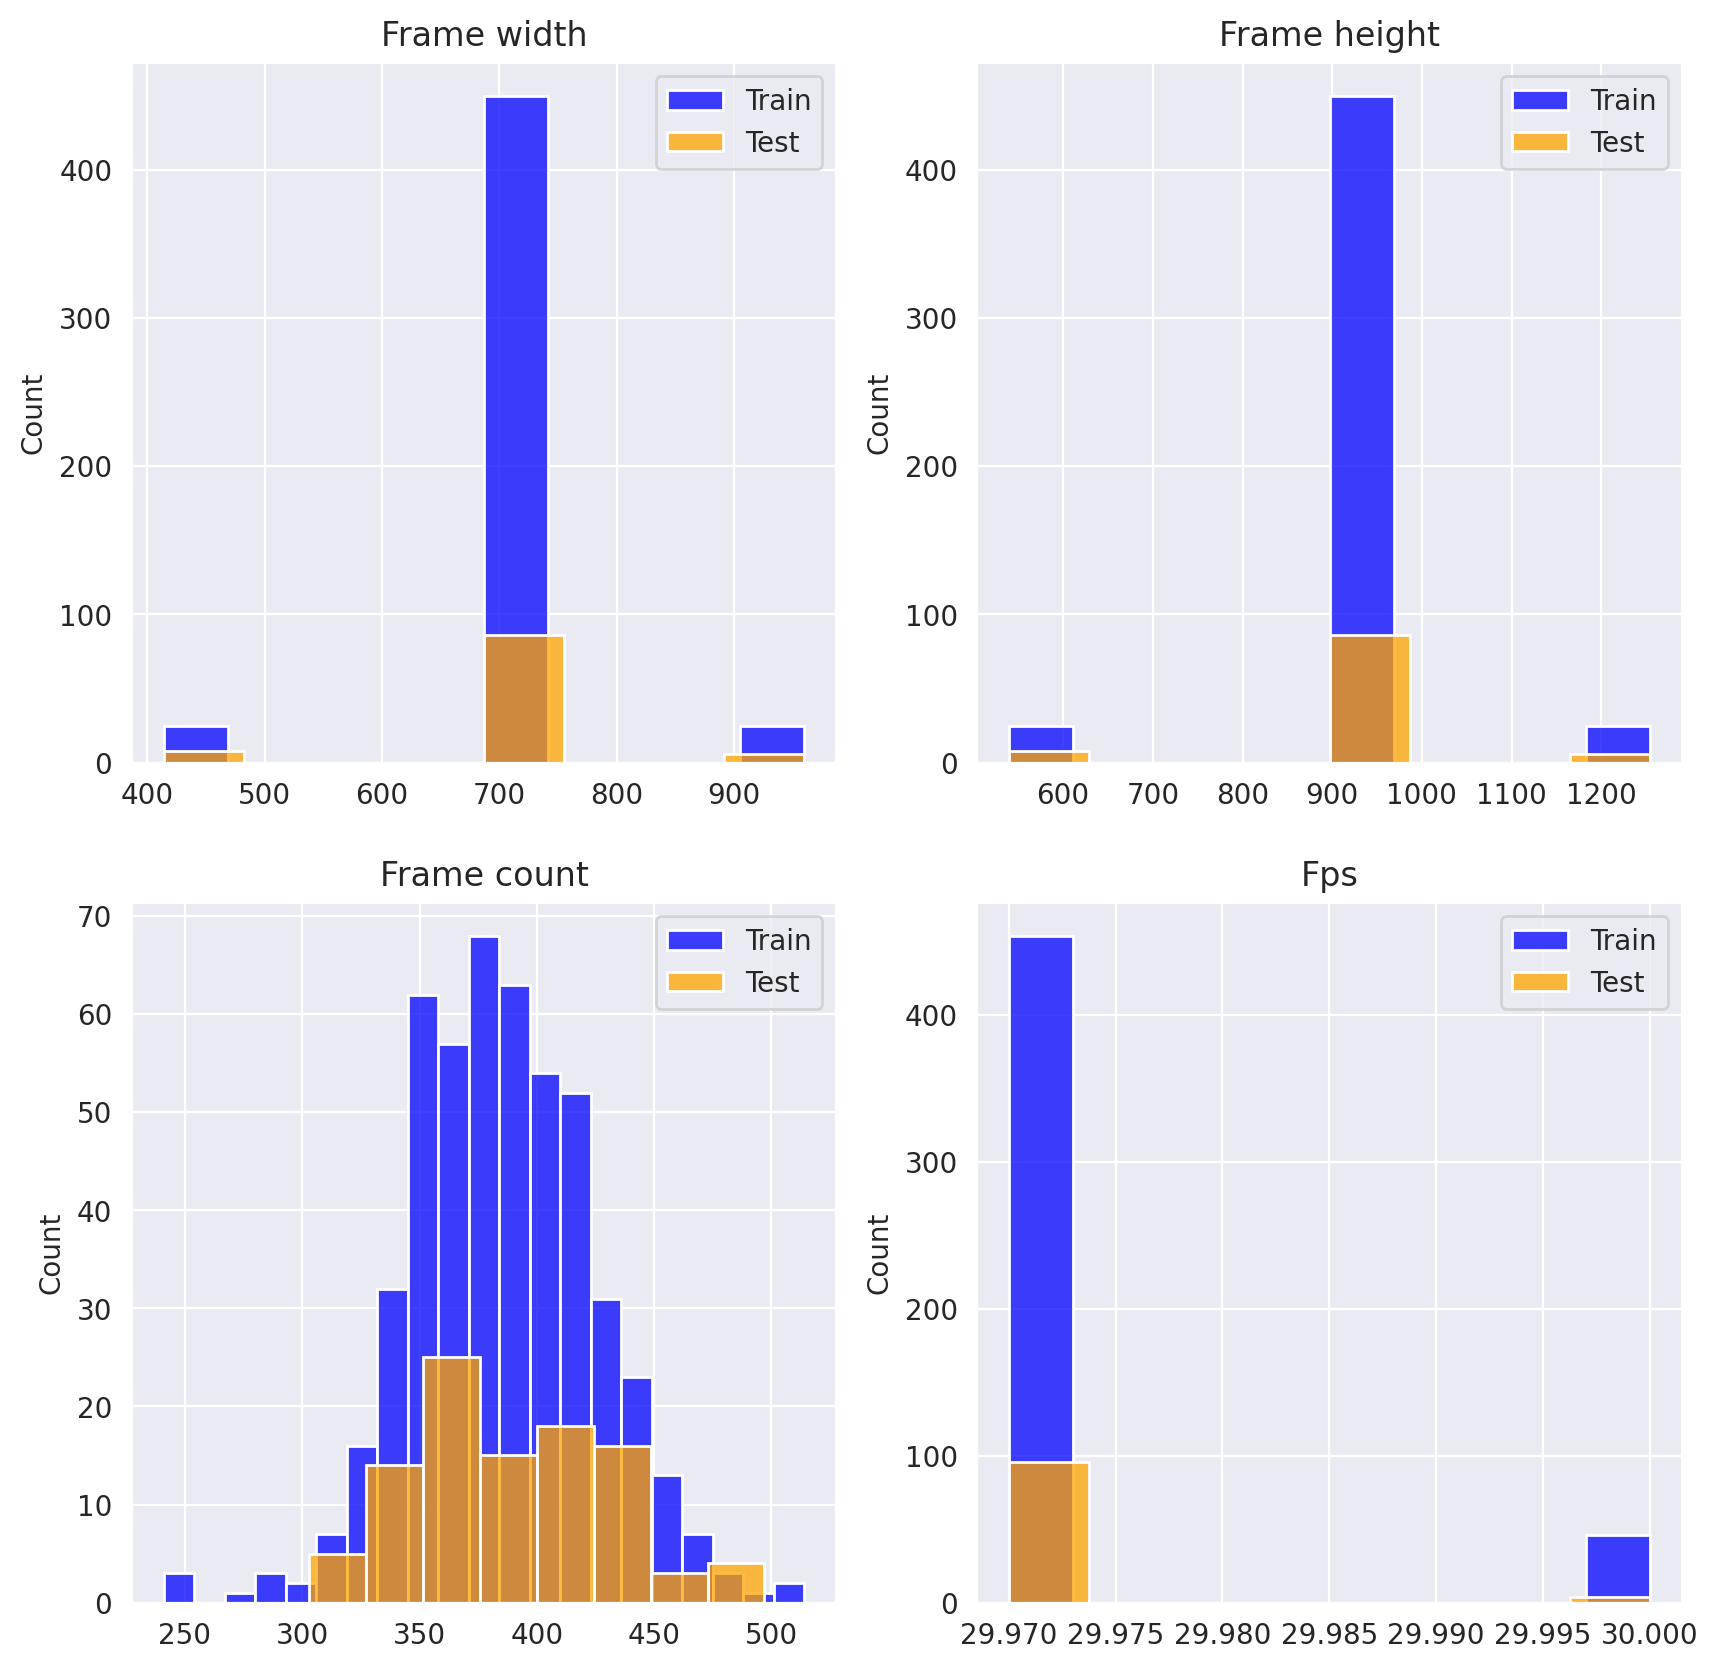

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(width_list_train, color="blue", label="Train", ax=axes[0,0])
sns.histplot(width_list_test, color="orange", label="Test", ax=axes[0,0])
axes[0,0].set_title("Frame width")
axes[0,0].legend()

sns.histplot(height_list_train, color="blue", label="Train", ax=axes[0,1])
sns.histplot(height_list_test, color="orange", label="Test", ax=axes[0,1])
axes[0,1].set_title("Frame height")
axes[0,1].legend()

sns.histplot(frame_count_list_train, color="blue", label="Train", ax=axes[1,0])
sns.histplot(frame_count_list_test, color="orange", label="Test", ax=axes[1,0])
axes[1,0].set_title("Frame count")
axes[1,0].legend()

sns.histplot(fps_list_train, color="blue", label="Train", ax=axes[1,1])
sns.histplot(fps_list_test, color="orange", label="Test", ax=axes[1,1])
axes[1,1].set_title("Fps")
axes[1,1].legend()

#### Видео пример

In [9]:
Video(train_original_mp4[42])

#### Пример кадров

In [10]:
sample_step = [1, 70, 140, 210, 280, 351]

Ширина кадров: 720
Высота кадров: 940
Количество кадров: 352
Кадров в секунду: 29.97002997002997


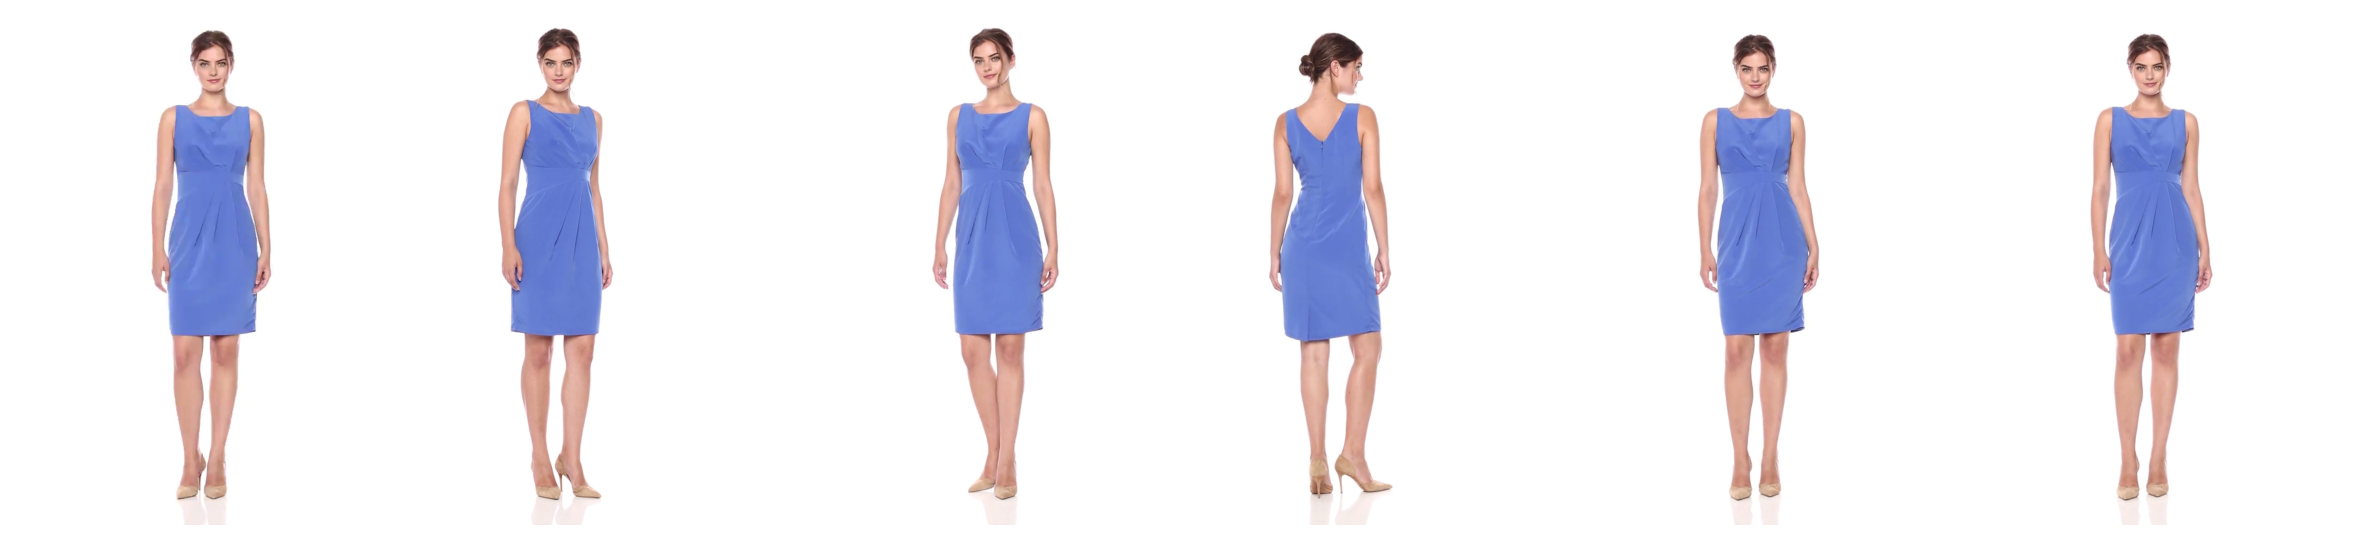

In [11]:
path = train_original_mp4[42]
get_params_mp4(path, log=True)
show_video_frames(path, sample_step)

Ширина кадров: 720
Высота кадров: 940
Количество кадров: 363
Кадров в секунду: 29.97002997002997


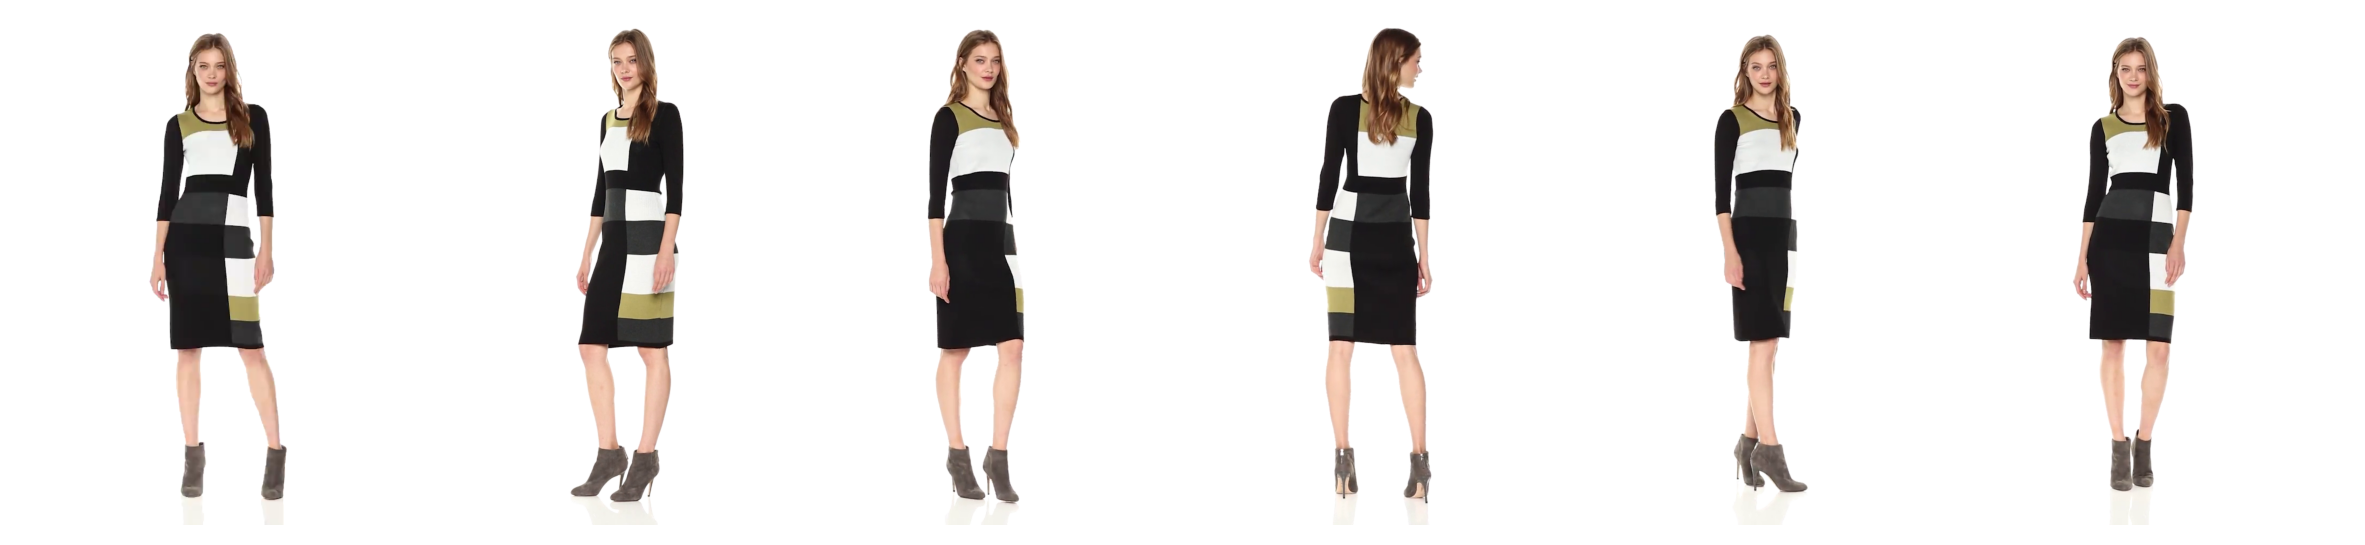

In [12]:
path = train_original_mp4[5]
get_params_mp4(path, log=True)
show_video_frames(path, sample_step)

Ширина кадров: 414
Высота кадров: 540
Количество кадров: 352
Кадров в секунду: 29.97002997002997


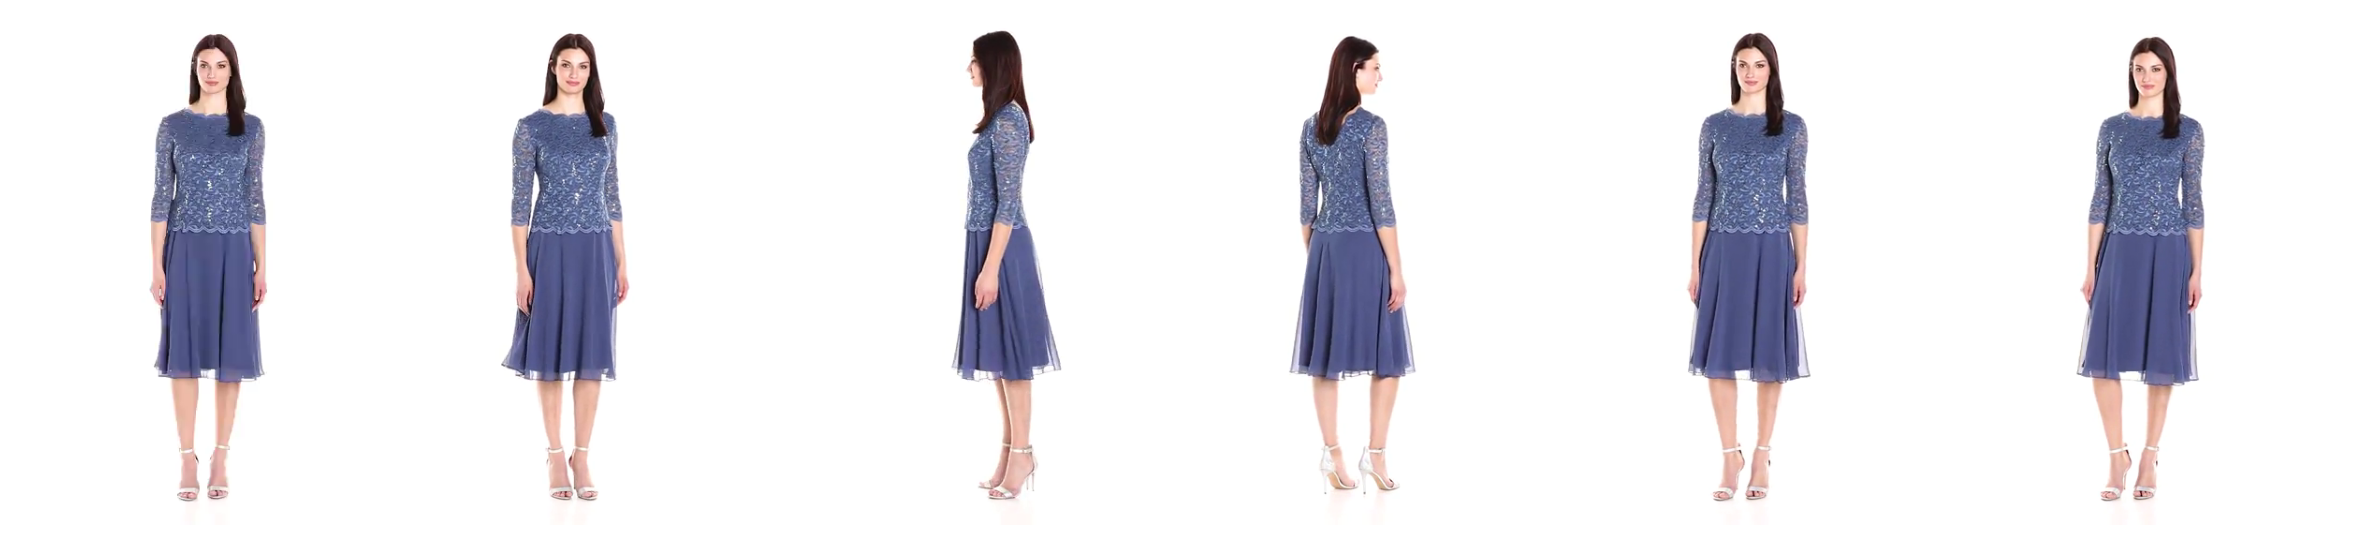

In [13]:
path = train_original_mp4[21]
get_params_mp4(path, log=True)
show_video_frames(path, sample_step)

Ширина кадров: 720
Высота кадров: 940
Количество кадров: 408
Кадров в секунду: 29.97002997002997


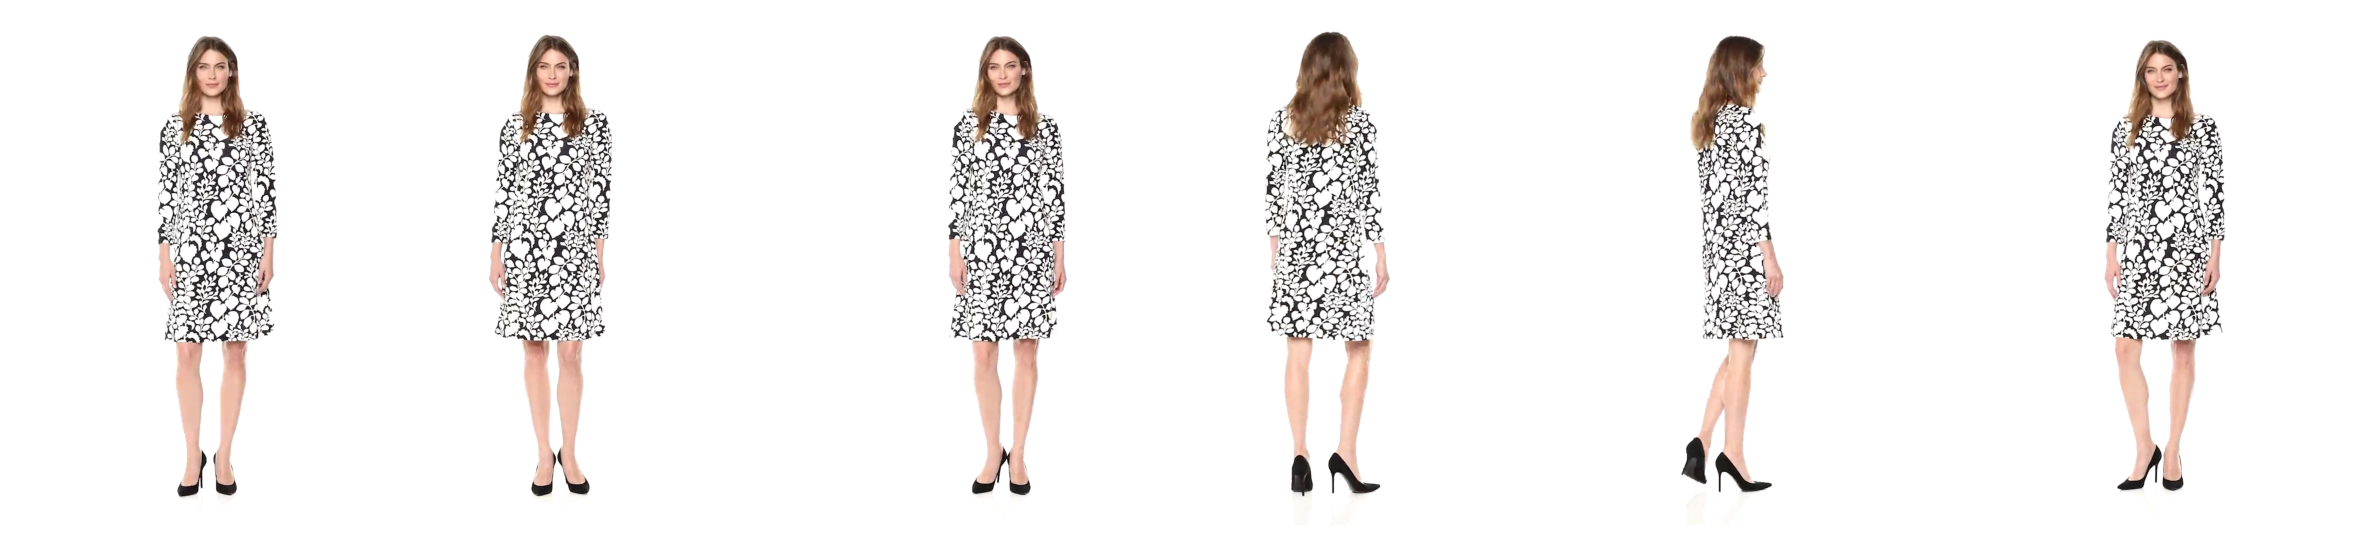

In [14]:
path = train_original_mp4[84]
get_params_mp4(path, log=True)
show_video_frames(path, sample_step)

Ширина кадров: 720
Высота кадров: 940
Количество кадров: 387
Кадров в секунду: 29.97002997002997


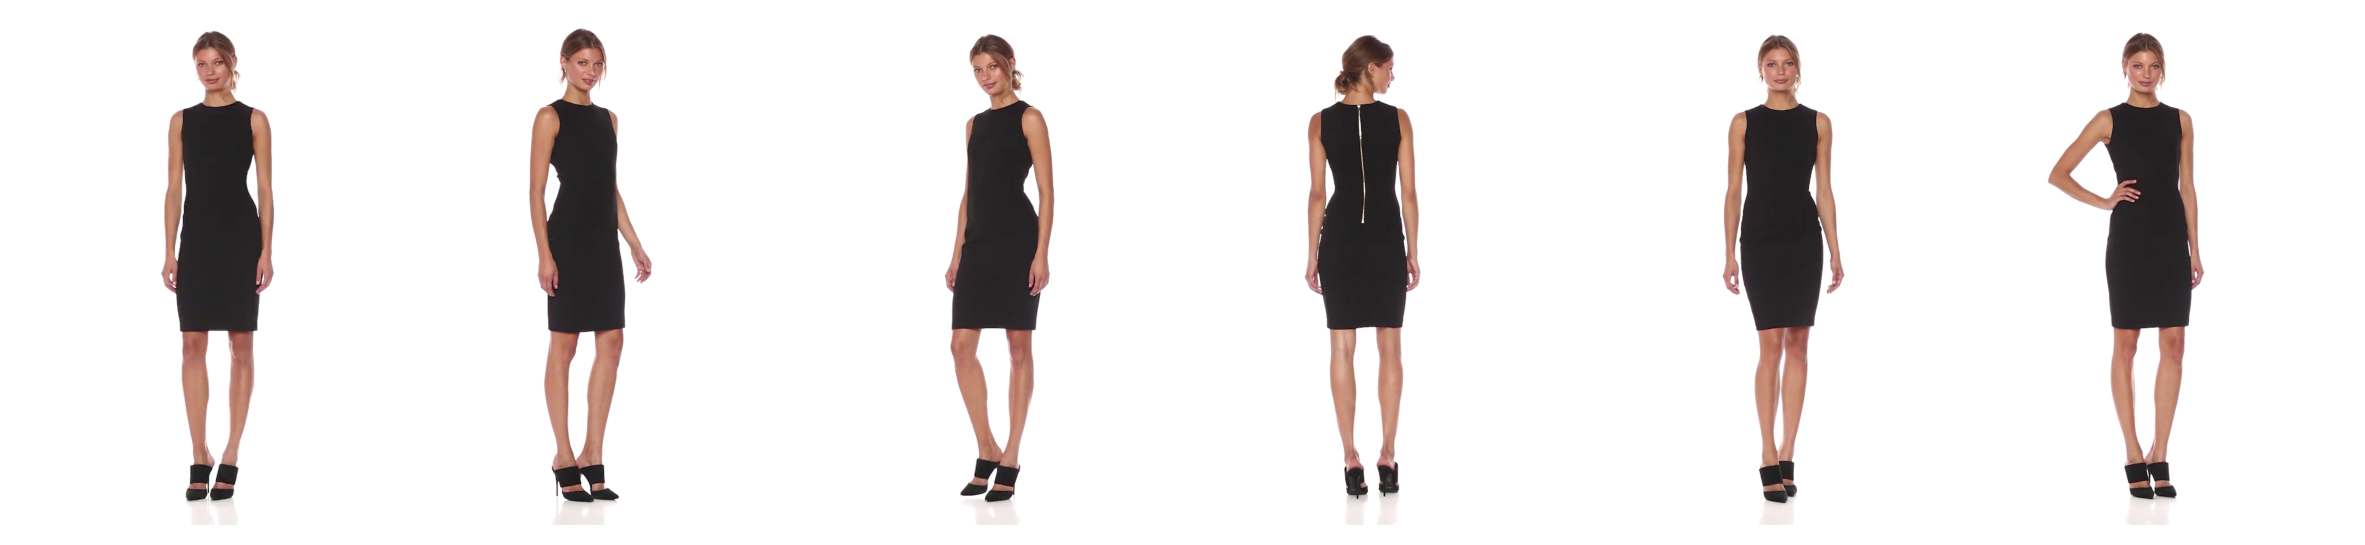

In [15]:
path = train_original_mp4[2]
get_params_mp4(path, log=True)
show_video_frames(path, sample_step)

### Train stage 1

Для обучения первого этапа нам требуется три составляюших. Мы хотим по входному кадру и целевой позе генерировать, кадр из видео соответствующий этой позе.

Входные данные:
* изначальный кадр
* поза целевого кадра

Таргет:
* целевой кадр из видео

In [16]:
# подгрудаем веса предобученного DWposeDetector
import os
os.chdir('../Moore-AnimateAnyone')
from src.dwpose import DWposeDetector

detector = DWposeDetector()
detector = detector.to(f"cuda")
os.chdir('../notebooks')

/home/jovyan/.mlspace/envs/310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/.mlspace/envs/310/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/jovyan/.mlspace/envs/310/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [17]:
np.random.seed(42)
generate_triplets(train_original_mp4, "../dataset/test/stage_1/", detector, max_triplet=200)

100%|██████████| 500/500 [06:25<00:00,  1.30it/s]


___